<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/EFP/EFP_example_pythia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 696kB 12.5MB/s 
     |████████████████████████████████| 2.9MB 50.9MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transform) package

In [3]:
!pip install POT

     |████████████████████████████████| 307kB 11.9MB/s 


The following code runs a quark gluon classifier using a EFP (EnergyFlow Polynomial) architecture. The input jets are Pythia-generated. The AUC tops out at around 0.89. Training on more data would take too long, as the EFP calculation is not GPU-optimized. Currently, we use 32,000 jets to train and 8,000 jets to test.

Using TensorFlow backend.


Loaded quark and gluon jets
Calculating d <= 5 EFPs for 40000 jets... Done
Done train/val/test split

EFPs d <= 1 AUC: 0.7867729814316986

Done train/val/test split

EFPs d <= 2 AUC: 0.8191114132800629

Done train/val/test split

EFPs d <= 3 AUC: 0.8598136518456763

Done train/val/test split

EFPs d <= 4 AUC: 0.8682256623738455

Done train/val/test split

EFPs d <= 5 AUC: 0.8821483073182342



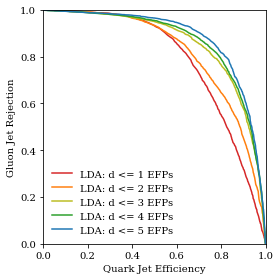

In [4]:
"""An example involving Energy Flow Polynomials (EFPs) and a linear
classifier (Fisher's Linear Discriminant by default). First, the 
[`EFPSet`](../docs/efp/#efpset) class is used to compute the EFPs
up to the specified `dmax`, the default being `dmax=5`. Then linear
classifiers are trained for different numbers of EFPs as input, 
determined by taking all EFPs up to degree `d` with `d` from `1` 
to `dmax`. The output of the example is a plot of the ROC curves
for the classifiers with different numbers of EFP inputs.
"""

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import LinearClassifier
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, standardize, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ###################################

# data controls
num_data = 40000
test_frac = 0.2

# efp parameters
dmax = 5
measure = 'hadr'
beta = 0.5

# plotting
colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:blue']

################################################################################

# load data
X, y = qg_jets.load(num_data)

print('Loaded quark and gluon jets')

# calculate EFPs
print('Calculating d <= {} EFPs for {} jets... '.format(dmax, num_data), end='')
efpset = ef.EFPSet(('d<=', dmax), measure='hadr', beta=beta)
masked_X = [x[x[:,0] > 0] for x in X]
X = efpset.batch_compute(masked_X)
print('Done')

# train models with different numbers of EFPs as input
rocs = []
for d in range(1, dmax+1):

    # build architecture
    model = LinearClassifier(linclass_type='lda')

    # select EFPs with degree <= d
    X_d = X[:,efpset.sel(('d<=', d))]

    # do train/val/test split 
    (X_train, X_test, y_train, y_test) = data_split(X_d, y, val=0, test=test_frac)
    print('Done train/val/test split')

    # train model
    model.fit(X_train, y_train)

    # get predictions on test data
    preds = model.predict(X_test)

    # get ROC curve if we have sklearn
    if roc_curve:
        rocs.append(roc_curve(y_test, preds[:,1]))

        # get area under the ROC curve
        auc = roc_auc_score(y_test, preds[:,1])
        print()
        print('EFPs d <= {} AUC:'.format(d), auc)
        print()

# make ROC curve plot if we have matplotlib
if plt:

    # some nicer plot settings 
    plt.rcParams['figure.figsize'] = (4,4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True

    # iterate over the ROC curves and plot them
    for i,d in enumerate(range(1, dmax+1)):
        plt.plot(rocs[i][1], 1-rocs[i][0], '-', color=colors[i], 
                                                label='LDA: d <= {} EFPs'.format(d))

    # axes labels
    plt.xlabel('Quark Jet Efficiency')
    plt.ylabel('Gluon Jet Rejection')

    # axes limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # make legend and show plot
    plt.legend(loc='lower left', frameon=False)
    plt.show()